# **26. Stable Diffusion, 너 Do? 나 Do!**

## **26-1. 들어가며**

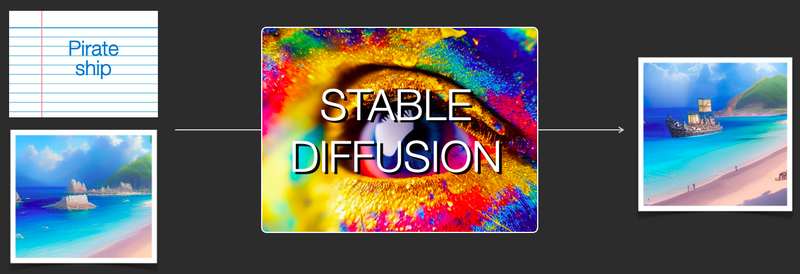

### **학습 내용**
---

* Latent space 탐사하기
* Dreambooth
* LoRA 랑 놀자

### **실습 목표**
---

* 잠재적 표현에 대해 체험해보면서 한 발자국 더 깊이 이해합니다.
* Stable diffusion의 fine-tuning 기법들을 알아보고, Dreambooth를 활용하기 위해 갖춰야할 내용들을 머릿속에 떠올릴 수 있습니다.
* 잠재 표현들이 담겨있는 가중치들을 활용하여, 이미지 생성 작업을 조정할 수 있는 파이프라인을 구성해볼 수 있습니다.

## **26-2. Stable diffusion 실습(1)**

해당 링크를 이용하여 Colab에 접속합니다.  
꼭 복제하여 사용해주세요.  
링크에선 실습을 진행하시고 이번 노드는 참고만 해주세요!  
로컬에서 진행하시는것도 좋답니다.

[GitHub 링크](https://gist.github.com/kspark-modulabs/1e16667d524cf6d62c30d00ddb72a714)

### **Latent 의 매력에 흠뻑 빠져봅시다!**
---

Stable diffusion 은 Latent Diffusion Model(LDM) 의 개념을 적극적으로 도입하면서, 모델의 연산 효율성과 생성 결과의 안정성을 모두 향상시킨 모델로 평가받습니다. \
Latent space 수준에서 조정되는 요소들이, 실제로 SD 모델의 내부에 어떤 영향을 미치는지 살펴봅시다. \
\
SD 모델 구조에서 LDM 이란 아래의 구성 요소를 조합하는 과정을 통해 구현할 수 있습니다.

> * Autoencoder
* CLIP embedding generator
* Unet with attention

우리는 Autoencoder 구조를 통해서 pixel space의 이미지가 더 적은 차원의 latent space 안에 머물도록 변환할 수 있습니다. \
SD 모델은 이 잠재 공간 안에 각 이미지들의 특성이 manifold 구조를 형성할 수 있도록 학습합니다. \
매니폴드 구조 안의 특정 지점으로부터 임베딩을 추출하는 작업을 sampling이라고 지칭하며, \
임베딩으로부터 사람이 시각적으로 인지할 수 있는 픽셀 이미지를 복원하는 작업을 decoding이라고 부릅니다. \
SD 모델은 미리 학습된 오토인코더의 디코더를 가져와 추정된 잠재 변수로부터 새로운 이미지를 생성합니다.

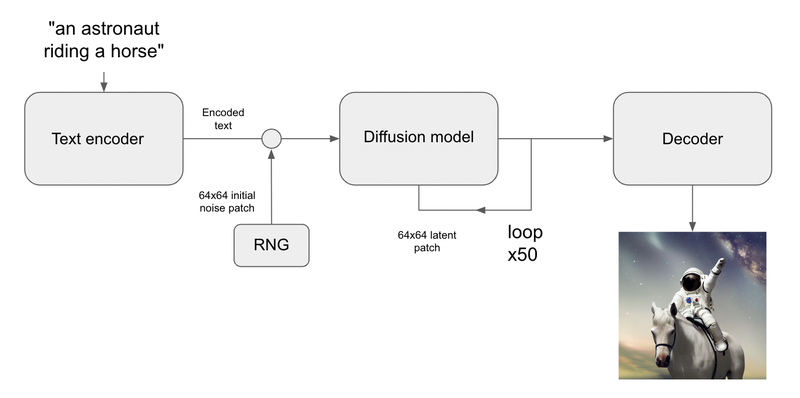

[출처: https://keras.io/examples/generative/random_walks_with_stable_diffusion/]

잠재 공간의 매니폴드는 연속적이면서, 보간적인 성질을 지닙니다.<br><br>

* **연속성**: 매니폴드 안에서 조금씩 이동하면, 해당 생성 이미지도 이에 맞춰 조금씩 변화합니다
* **보간성**: 매니폴드 안에 특정한 두 점 A, B 를 상상해봅시다. A와 B 사이의 중간 지점은 매니폴드 내의 경로를 통해서 A부터 B로 이동할 수 있습니다. 이 중간점들은 모두 이미지를 생성하는데 유효합니다.

<br>SD 모델은 최종적으로 두 종류의 잠재 공간을 활용하게 됩니다. 하나는 **인코더를 통해 얻은 임베딩으로 학습한 이미지적 표현들이 담긴 공간**이며, \
**다른 하나는 사전에 학습된 후 이미지와 함께 미세조정을 거친 프롬프트 잠재 공간**입니다. \
이런 사실을 볼 때, SD 모델은 이미지 모델이면서 동시에 자연어 모델이라고 부를 수 있겠습니다. \
\
자 그러면 본격적으로 SD 모델의 잠재 공간을 탐험해 보겠습니다. \
일단 빠르게 준비 과정을 거쳐야겠죠! 먼저 필요한 환경요소를 설치해볼까요! \
이번 스텝에서 사용할 모델은 `diffusers` 에 사전학습된 Stable diffusion입니다.

In [ ]:
!pip install --upgrade pip
!pip install torch torchvision torchaudio diffusers transformers accelerate --upgrade --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 22.5 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.2/865.2 MB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.1/393.1 MB 37.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 122.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 173.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.7/897.7 kB 50.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 571.0/571.0 MB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.2/200.2 MB 74.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 58.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 59.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.2/158.2 MB 72

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


scheduler_config-checkpoint.json:   0%|          | 0.00/209 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

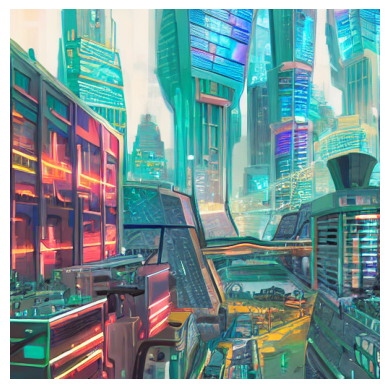

In [ ]:
import torch
from diffusers import StableDiffusionPipeline
import matplotlib.pyplot as plt
import numpy as np
import math
from PIL import Image

# GPU가 사용 가능한지 확인하고, 사용 가능한 경우 GPU와 float16을 설정합니다.
device = "cuda" if torch.cuda.is_available() else "cpu"

# Pre-trained Stable Diffusion 모델을 불러옵니다.
# 모델 아이디는 원하는 버전(예: "CompVis/stable-diffusion-v1-4" 또는 "runwayml/stable-diffusion-v1-5")에 따라 조정할 수 있습니다.
model_id = "CompVis/stable-diffusion-v1-4"

pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe = pipe.to(device)

# 이제 pipe를 사용하여 텍스트-투-이미지 생성 등을 수행할 수 있습니다.
prompt = "A futuristic cityscape, vibrant and detailed"
image = pipe(prompt).images[0]

# 생성된 이미지를 출력합니다.
plt.imshow(np.array(image))
plt.axis("off")
plt.show()

---
### **텍스트 프롬프트 사이사이를 관찰해볼까요?**

두 가지 숫자 사이에는 쉽게 중간값을 갖는 지점을 떠올려볼 수 있습니다. \
단어와 단어의 사이는 어떤가요? 서로 의미에서 차이가 나는 두 단어 사이에 또 다른 단어가 존재하지않을까요? \
문장과 문장의 경우엔 어떻게 표현할 수 있을까요? 유연한 구조를 가지면서 중간 정도의 의미를 담고있는 문장을 어떻게 구성하면 좋을까요? \
\
먼저, 두 가지의 프롬프트를 설정해줍니다. 이 문장들은 각각 모델 내부의 인코더 구조로 들어가 임베딩 형태로 변환됩니다.

In [ ]:
# 프롬프트와 보간 단계 수 정의
prompt_1 = "A futuristic cityscape, vibrant and detailed"
prompt_2 = "A robotic wolf with glowing red eyes, cybernetic design, cinematic background"
interpolation_steps = 3

# 토크나이저를 사용해 텍스트를 토큰화합니다.
inputs_1 = pipe.tokenizer(prompt_1, padding="max_length", max_length=pipe.tokenizer.model_max_length, return_tensors="pt")
inputs_2 = pipe.tokenizer(prompt_2, padding="max_length", max_length=pipe.tokenizer.model_max_length, return_tensors="pt")

# CPU에 있는 텐서를 GPU로 이동
inputs_1 = {k: v.to(device) for k, v in inputs_1.items()}
inputs_2 = {k: v.to(device) for k, v in inputs_2.items()}

# 텍스트 인코더를 사용해 프롬프트의 임베딩을 얻습니다.
with torch.no_grad():
    encoding_1 = pipe.text_encoder(**inputs_1).last_hidden_state  # shape: (1, seq_len, emb_dim)
    encoding_2 = pipe.text_encoder(**inputs_2).last_hidden_state

# 배치 차원 제거 (1, seq_len, emb_dim) -> (seq_len, emb_dim)
encoding_1 = encoding_1.squeeze(0)
encoding_2 = encoding_2.squeeze(0)

# 두 인코딩 사이를 선형 보간합니다.
alphas = torch.linspace(0, 1, steps=interpolation_steps, device=encoding_1.device)
# 각 보간 단계마다 encoding_1과 encoding_2의 가중 평균을 계산합니다.
interpolated_encodings = [(1 - alpha) * encoding_1 + alpha * encoding_2 for alpha in alphas]
# 보간 결과를 하나의 텐서로 스택 (shape: (interpolation_steps, seq_len, emb_dim))
interpolated_encodings = torch.stack(interpolated_encodings)

# 임베딩의 shape 출력
print(f"Encoding shape: {encoding_1.shape}")

Encoding shape: torch.Size([77, 768])


**Q. 위 코드에서 모델의 text embedding 을 통과하며 인코딩된 prompt 는 각각 어떤 모양의 텐서 형식을 가지고 있나요? \
보간을 통해 만들어진 interpolated_encodings 의 값도 출력해봅시다.**<br>
A. [ 답변을 적어볼까요! ]<br><br>

<details><summary>💡예시답안 확인하기💡</summary>

A. Encoding shape: (77, 768)</details>

일정 간격으로 임베딩을 나눠놓을 수 있게 되었습니다. 이 값들의 차이가 출력 결과에 어떻게 반영이 될 지 매우 궁금합니다!

In [ ]:
# 시드 설정 및 생성기 초기화
seed = 123
generator = torch.Generator(device=device).manual_seed(seed)

# latent 공간 크기: (batch_size, 4, height, width)
latent_height = 512 // 8  # 64
latent_width = 512 // 8   # 64

# interpolation_steps 만큼의 노이즈(초기 잠재 변수)를 생성
latents = torch.randn(
    (interpolation_steps, 4, latent_height, latent_width),
    generator=generator,
    dtype=torch.float16,
    device=device
)

# latents에 미리 생성한 노이즈를 전달합니다.
images = pipe(
    prompt_embeds=interpolated_encodings,
    latents=latents,
    generator=generator
).images

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
def export_as_gif(filename, images, frames_per_second=10, rubber_band=False):
    if rubber_band:
        images += images[2:-1][::-1]
    images[0].save(
        filename,
        save_all=True,
        append_images=images[1:],
        duration=1000 // frames_per_second,
        loop=0,
    )

export_as_gif(
    "doggo-and-fruit-5.gif",
    images,
    frames_per_second=2,
    rubber_band=True,
)

움직이는 그림으로 구성해놓으니 지역적인 이미지 특징들이 점차 변해가는 것이 잘 보입니다. \
단계를 더 잘게 나누어 보면 훨씬 부드럽게 형상이 변할 수 있을 것 같습니다.

In [ ]:
# 설정
interpolation_steps = 3  # 원래 생성할 샘플 수
batch_size = 3

# interpolated_encodings는 이전에 (interpolation_steps, 77, 768) 모양으로 생성됨
total = interpolated_encodings.shape[0]
num_batches = math.ceil(total / batch_size)
padding_size = num_batches * batch_size - total

if padding_size > 0:
    # 마지막 샘플을 복제해서 패딩 (여기서는 마지막 샘플을 반복)
    pad_encodings = interpolated_encodings[-1:].expand(padding_size, -1, -1)
    interpolated_encodings = torch.cat([interpolated_encodings, pad_encodings], dim=0)

# 이제 전체 샘플 수는 num_batches * batch_size가 됨
batched_encodings = torch.split(interpolated_encodings, batch_size)

# 잠재(latent) 공간의 크기 계산 (일반적으로 512/8 = 64)
latent_height = 512 // 8  # 64
latent_width = 512 // 8   # 64

# 각 보간 단계마다 사용할 노이즈(초기 잠재 변수)를 생성합니다. noise 텐서의 shape: (interpolation_steps, 4, latent_height, latent_width)
noise = torch.randn(
    (total, 4, latent_height, latent_width),
    generator=generator,
    dtype=torch.float16,
    device=device
)
# noise도 배치 크기의 배수가 아니면 패딩
if padding_size > 0:
    pad_noise = noise[-1:].expand(padding_size, 4, latent_height, latent_width)
    noise = torch.cat([noise, pad_noise], dim=0)

batched_latents = torch.split(noise, batch_size)

# 배치별로 이미지를 생성합니다.
images = []
for i in range(len(batched_encodings)):
    output = pipe(
        prompt_embeds=batched_encodings[i],
        latents=batched_latents[i],
        num_inference_steps=25,
        generator=generator
    )
    images += output.images

export_as_gif("doggo-and-fruit-150.gif", images, rubber_band=True)

  0%|          | 0/25 [00:00<?, ?it/s]

시간 간격으로 변화를 관찰했다면, 이번엔 일정 거리만큼 떨어진 임베딩들 사이를 비교해봅시다. \
4 개의 프롬프트를 각 코너에 배치하고, 극단의 사이를 선형적으로 채워보겠습니다. \
어떤 특징들을 발견할 수 있을 지 궁금하네요.

In [ ]:
# 프롬프트 정의
prompt_1 = "A watercolor painting of a Golden Retriever at the beach"
prompt_2 = "A still life DSLR photo of a bowl of fruit"
prompt_3 = "The eiffel tower in the style of starry night"
prompt_4 = "An architectural sketch of a skyscraper"

# 보간 관련 설정
interpolation_steps = 6
batch_size = 3
# 총 생성할 임베딩 수: 6 * 6 = 36, 배치 수 = 36 // 3 = 12
batches = (interpolation_steps**2) // batch_size

def get_encoding(prompt):
    inputs = pipe.tokenizer(
        prompt,
        padding="max_length",
        max_length=pipe.tokenizer.model_max_length,
        return_tensors="pt"
    )
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        encoding = pipe.text_encoder(**inputs).last_hidden_state  # shape: (1, seq_len, emb_dim)
    return encoding.squeeze(0).to(device)  # shape: (seq_len, emb_dim)

# 각 프롬프트에 대한 인코딩을 GPU로 가져옵니다.
encoding_1 = get_encoding(prompt_1)
encoding_2 = get_encoding(prompt_2)
encoding_3 = get_encoding(prompt_3)
encoding_4 = get_encoding(prompt_4)

# 1차 보간: encoding_1 ~ encoding_2, encoding_3 ~ encoding_4
alphas = torch.linspace(0, 1, interpolation_steps, device=device)
lin1 = torch.stack([ (1 - alpha) * encoding_1 + alpha * encoding_2 for alpha in alphas ])
lin2 = torch.stack([ (1 - alpha) * encoding_3 + alpha * encoding_4 for alpha in alphas ])

# 2차 보간: lin1 ~ lin2 (결과 shape: (interpolation_steps, interpolation_steps, seq_len, emb_dim))
betas = torch.linspace(0, 1, interpolation_steps, device=device)
interpolated_encodings = torch.stack([ (1 - beta) * lin1 + beta * lin2 for beta in betas ])

# reshape to (interpolation_steps**2, seq_len, emb_dim) => (36, 77, 768)
interpolated_encodings = interpolated_encodings.view(interpolation_steps**2, *lin1.shape[1:])
interpolated_encodings = interpolated_encodings.to(device)

# 배치별로 분할 (각 배치에 batch_size개씩)
batched_encodings = torch.split(interpolated_encodings, batch_size)

# 이미지 생성을 위한 latent 공간의 크기 (일반적으로 512/8 = 64)
latent_height = 512 // 8  # 64
latent_width = 512 // 8   # 64

images = []
# 각 배치마다 노이즈(초기 잠재 변수)를 생성하고 파이프라인 호출
for batch in batched_encodings:
    current_batch_size = batch.shape[0]
    latents = torch.randn(
        (current_batch_size, 4, latent_height, latent_width),
        generator=generator,
        dtype=torch.float16,
        device=device
    )
    batch = batch.to(device)
    output = pipe(
        prompt_embeds=batch,
        latents=latents,
        num_inference_steps=25,
        generator=generator
    )
    images.extend(output.images)

# grid를 만들어 이미지를 저장하는 함수
def plot_grid(images, path, grid_size, scale=2):
    fig = plt.figure(figsize=(grid_size * scale, grid_size * scale))
    fig.tight_layout()
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.margins(x=0, y=0)
    for row in range(grid_size):
        for col in range(grid_size):
            index = row * grid_size + col
            ax = plt.subplot(grid_size, grid_size, index + 1)
            ax.imshow(np.array(images[index]))
            ax.axis("off")
            plt.margins(x=0, y=0)
    plt.savefig(fname=path, pad_inches=0, bbox_inches="tight", transparent=False, dpi=60)
    plt.close(fig)

# grid_size는 interpolation_steps (6)
plot_grid(images, "4-way-interpolation.jpg", interpolation_steps)

너무 정적인 변화만 관찰하다보니 심심하게 느껴질 수 있겠네요. \
`diffusion_noise` 인자를 함수 입력에서 제외하면, 노이즈가 고정되지 않고 더 다양해지면서 출력 결과도 달라지는 것을 볼 수 있습니다.

In [ ]:
images = []
for batch in range(batches):
    batch_encodings = batched_encodings[batch]  # shape: (batch_size, seq_len, emb_dim)
    current_batch_size = batch_encodings.shape[0]
    # 각 배치마다 새로운 노이즈(잠재 변수)를 생성합니다.
    latents = torch.randn(
        (current_batch_size, 4, latent_height, latent_width),
        generator=generator,
        dtype=torch.float16,
        device=device
    )
    # 파이프라인 호출: 텍스트 임베딩(prompt_embeds)와 노이즈(latents)를 전달합니다.
    output = pipe(
        prompt_embeds=batch_encodings,
        latents=latents,
        num_inference_steps=25,
        generator=generator
    )
    images.extend(output.images)

plot_grid(images, "4-way-interpolation-varying-noise.jpg", interpolation_steps)

### **텍스트 프롬프트를 자유롭게 거닐어 봅시다.**

In [ ]:
# 약 10분 정도 걸립니다.
walk_steps = 150
batch_size = 3
batches = walk_steps // batch_size
step_size = 0.005

encoding = get_encoding("The Eiffel Tower in the style of starry night")

# 각 스텝마다 더할 변화량(delta) 생성
delta = torch.ones_like(encoding) * step_size

# 워크 스텝에 따른 인코딩 리스트 생성 (각 스텝마다 인코딩에 delta를 더함)
walked_encodings = []
for step_index in range(walk_steps):
    # clone()을 사용하여 현재 encoding의 복사본을 저장 (참조가 누적되지 않도록)
    walked_encodings.append(encoding.clone())
    encoding = encoding + delta

walked_encodings = torch.stack(walked_encodings)
batched_encodings = torch.split(walked_encodings, batch_size)

# 이미지 생성
images = []
for batch in batched_encodings:
    current_batch_size = batch.shape[0]
    latents = torch.randn(
        (current_batch_size, 4, latent_height, latent_width),
        generator=generator,
        dtype=torch.float16,
        device=device
    )
    output = pipe(
        prompt_embeds=batch,
        latents=latents,
        num_inference_steps=25,
        generator=generator
    )
    images.extend(output.images)

export_as_gif("eiffel-tower-starry-night.gif", images, rubber_band=True)

In [ ]:
prompt = "An oil paintings of cows in a field next to a windmill in Holland"
encoding = get_encoding(prompt)

walk_steps = 150
batch_size = 3
batches = walk_steps // batch_size

latent_channels = 4
latent_height = 512 // 8
latent_width = 512 // 8

base_noise_shape = (latent_channels, latent_height, latent_width)

# 두 방향의 난수 노이즈
walk_noise_x = torch.randn(base_noise_shape, dtype=torch.float64, device=device)
walk_noise_y = torch.randn(base_noise_shape, dtype=torch.float64, device=device)

# walk 스케일 계산: 0~2 사이를 interpolation, 각각 코사인과 사인 적용
walk_scale_x = torch.cos(torch.linspace(0, 2, walk_steps, device=device) * math.pi)
walk_scale_y = torch.sin(torch.linspace(0, 2, walk_steps, device=device) * math.pi)

# tensordot 대신 broadcasting을 사용: 각 스케일에 대해 base noise 곱하기
noise_x = walk_scale_x.view(walk_steps, 1, 1, 1) * walk_noise_x
noise_y = walk_scale_y.view(walk_steps, 1, 1, 1) * walk_noise_y

# 최종 노이즈: (walk_steps, 4, 64, 64)
noise = noise_x + noise_y
noise = noise.to(torch.float16)
batched_noise = torch.split(noise, batch_size, dim=0)

# 이미지 생성
images = []
encoding_expanded = encoding.unsqueeze(0).to(torch.float16)

for batch_noise in batched_noise:
    current_batch_size = batch_noise.shape[0]
    prompt_embeds = encoding_expanded.expand(current_batch_size, -1, -1)

    output = pipe(
        prompt_embeds=prompt_embeds,
        latents=batch_noise,
        num_inference_steps=25,
        generator=generator
    )
    images.extend(output.images)

export_as_gif("cows.gif", images)

## **26-3. Stable diffusion 실습(2)**

Stable diffusion 모델은 1024x1024 크기의 이미지를 생성할 수 있으며, 다양한 스타일과 질감을 표현할 수 있습니다. \
이를 위해 SD 모델이 활용하는 파라미터수는 약 23억 개 입니다. '[With 860 millions of parameters in the U-Net and 123 millions in the text encoder](https://en.wikipedia.org/wiki/Stable_Diffusion)' \
\
이렇게 커다란 모델이다보니 파라미터 전체를 한꺼번에 학습하기 위해서는 여전히 높은 하드웨어 사양을 요구합니다. 따라서 파라미터를 일부분만 갱신하더라도 더 가볍고 효과적으로 미세조정하는 방법이 다양하게 개발되고있습니다.

> * Fine tuning, Textual Inversion, **DreamBooth**, LoRA, ...

[What are we fine-tuning?](https://pytorch.kr/blog/2024/torchtune-fine-tune-llms/) \
\
모델의 모든 파라미터를 Fine-tuning 에 참여시키는 것은 이미지의 특성이 수정되는 효과에 비해 과도한 연산량을 소모합니다. \
때문에 여러 경로를 통해 모델의 일부분만 가지고 우리가 주입하고 싶은 데이터를 스며들도록 하는 것이 포인트입니다. \
\
Huggingface - diffusers API 를 활용해 미세조정 작업을 수행해볼까요?

> 1. 먼저 Huggingface 에 로그인
2. 우측 상단의 Settings로 이동
3. Access Token 페이지에서 New Token을 Read로 발급
4. API key 를 복사

해당 코드에 API key 를 넣고 실행해주세요

In [ ]:
# !시작하기 전에 세션을 한번 초기화해주세요!
!mkdir -p ~/.huggingface
HUGGINGFACE_TOKEN = # [[YOUR API KEY]]
!echo -n "{HUGGINGFACE_TOKEN}" > ~/.huggingface/token

아래 링크의 레포지토리를 복사해와야 합니다. \
코드블럭을 실행시키면 diffusers를 clone해옵니다.

In [ ]:
!git clone https://github.com/huggingface/diffusers ./diffusers_git

아래 명령어를 터미널에 입력하여 버전을 고정시켜주어야 합니다. \
저희는 최신 Diffusers 를 사용하도록 하겠습니다. \
다른 버전을 이용하고 싶으시다면 git tags 명령어를 통해 이용 가능한 버전을 확인하세요.

In [ ]:
!cd diffusers_git && git checkout main

자 이제 diffusers를 설치해볼까요?

In [ ]:
!pip install -e ./diffusers_git

In [ ]:
!pip list | grep diffusers

설치가 잘 되었다면 위의 결과에서 `diffusers (버전) /content/diffusers_git` 이라는 결과가 보일겁니다. \
이제 diffusers가 준비되었습니다! \
\
Stable diffusion 원본을 그대로 활용하는 것은 적절한 하드웨어를 갖추지 않은 이상 쉽지않습니다. \
\
오늘은 실습을 위해 12 GB GPU에서도 구동할 수 있는 가벼운 모델을 불러와 학습시켜보겠습니다. \
\
먼저 몇가지 의존성 모듈을 설치해줘야합니다.

In [ ]:
!pip install -r ./diffusers_git/examples/dreambooth/requirements.txt bitsandbytes xformers accelerate triton --upgrade --quiet

Accelerate 모듈을 활용하기 위해서 configuration 을 초기화해줍니다.

In [ ]:
!accelerate config default

Dreambooth 방식으로 미세조정을 수행하기 위해서는 몇 가지 종류의 데이터를 준비해야합니다.

> * Unique class: 학습 시키려는 예시를 포괄하는 dog, person 등의 중간 카테고리로 클래스를 설정해줍니다. 우리는 dog 를 사용하도록 하겠습니다.
* Unique identifier: 학습 시키고싶은 특정한 대상을 위해, 이전 어휘와 겹치지않는 유일한 단어를 identifier, ID 로 설정해줍니다. 이때 아무 의미를 지니지 않은 무작위의 단어 조합을 선택하도록합니다. 이 예시에서는 **`sks`** 와 같이 최대한 아무 의미를 가지지 않는 단어를 사용했습니다.
* Class prompt: 특정한 ID 를 제외하고 이미지에 대한 설명을 넣어주도록 합니다. "a photo of dog".
* Instance prompt: 학습시킬 대상 이미지들이 표기되어있는 설명 문장을 입력합니다. 예시로 다음과 같은 형식을 사용할 수 있습니다 - f"a photo of {unique_id} {unique_class}". 예제에서 사용할 ID 와 클래스를 조합하면 "a photo of sks dog" 와 같은 문장을 만들 수 있습니다.
* Class images: class prompt 에 맞추어 학습시킬 대상을 포함하는 넓은 범위의 이미지를 모읍니다. 일반적으로 200-300 장 정도면 충분합니다.
* Instance images: instance prompt 와 연결하여 학습할 수 있는 이미지를 모읍니다. 학습시키고싶은 동일한 대상으로 3 - 5 장 만 마련하면 됩니다.

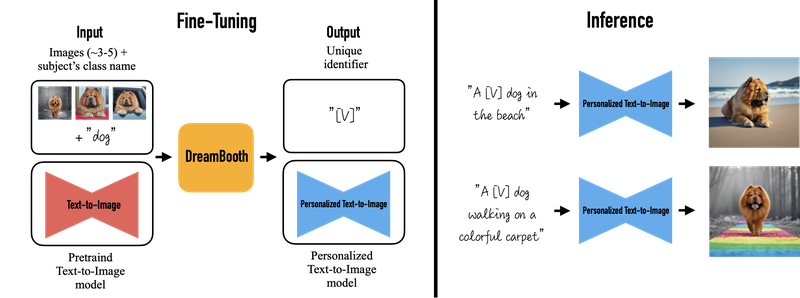

[출처: https://dreambooth.github.io]

---
예제 튜토리얼을 따라 사용할 이미지 데이터를 불러오겠습니다. \
dreambooth 를 위해서는 5 장 정도의 instance 이미지만 있으면 충분합니다! 놀랍지않나요? \
나중에 SD 모델에 적용하고싶은 대상있다면, 대상의 모습이 담긴 이미지를 모아 아래처럼 경로를 만들어 저장해줍니다.

In [ ]:
from huggingface_hub import snapshot_download

local_dir = "./diffusers_git/examples/dreambooth/dog"
snapshot_download(
    "diffusers/dog-example",
    local_dir=local_dir, repo_type="dataset",
    ignore_patterns=".gitattributes",
)

SD 모델의 학습 코드에는 여러 종류의 인자들이 입력되어야합니다. \
각 조건들을 좀더 편리하게 입력하기 위해 아래와 같이 셸 스크립트 shell script를 구성해주어야합니다. CLI 터미널에서 `sh` 명령어로 해당 스크립트를 실행할 수 있습니다.<br><br>

> Ipython 의 다양한 매직 커맨드 %, %%를 활용하면 유용한 작업을 쉽게 실행할 수 있습니다. \
`%%writefile {file_path}` 커맨드는 셀 안의 내용을 텍스트 파일로 저장해줍니다

<br>셸 스크립트 내의 외부환경변수 `MODEL_NAME` 은 [Huggingface](https://huggingface.co/CompVis/stable-diffusion-v1-4) 에 등록된 여러 사전학습 모델들을 이름으로 쉽게 불러올 수 있습니다. \
`INSTANCE_DIR` 에는 학습시키고 싶은 특정 대상의 이미지를 5-6 장 정도 넣어줍니다. \
`CLASS_DIR`은 학습시키고 싶은 대상과 닮은 참고 이미지들을 넣어줍니다. 여유가 된다면 200 - 300 장 정도 채워줄 수 있습니다. 빠른 진행을 위해 over-fitting 을 감수하고 이번에는 인스턴스와 동일하게 입력하도록 합니다. \
`OUTPUT_DIR` 경로에는 학습을 통해 만들어진 파라미터, 출력 결과 등이 저장됩니다. \
\
다만, 이번 노드에서는 입력해야하는 텍스트가 많아 data 폴더 안에 셸 스크립트를 작성하는 코드를 미리 준비해놓았습니다. 구성 내용은 아래와 같습니다.

```shell
export MODEL_NAME="CompVis/stable-diffusion-v1-4"
export INSTANCE_DIR="./diffusers_git/examples/dreambooth/dog"
export CLASS_DIR="./diffusers_git/examples/dreambooth/dog"
export OUTPUT_DIR="./diffusers_git/examples/dreambooth/data"

echo $MODEL_NAME

accelerate launch /aiffel/diffusers_git/examples/dreambooth/train_dreambooth.py \
  --pretrained_model_name_or_path=$MODEL_NAME  \
  --instance_data_dir=$INSTANCE_DIR \
  --class_data_dir=$CLASS_DIR \
  --output_dir=$OUTPUT_DIR \
  --instance_prompt="a photo of sks dog" \
  --class_prompt="a photo of dog" \
  --resolution=512 \
  --train_batch_size=1 \
  --with_prior_preservation --prior_loss_weight=1.0 \
  --gradient_accumulation_steps=1 --gradient_checkpointing \
  --use_8bit_adam \
  --enable_xformers_memory_efficient_attention \
  --set_grads_to_none \
  --learning_rate=2e-6 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --num_class_images=5 \
  --max_train_steps=100 \
	```
```

In [ ]:
script_content = """#!/bin/bash
export MODEL_NAME="CompVis/stable-diffusion-v1-4"
export INSTANCE_DIR="./diffusers_git/examples/dreambooth/dog"
export CLASS_DIR="./diffusers_git/examples/dreambooth/dog"
export OUTPUT_DIR="./diffusers_git/examples/dreambooth/data"

echo $MODEL_NAME

accelerate launch ./diffusers_git/examples/dreambooth/train_dreambooth.py \\
  --pretrained_model_name_or_path=$MODEL_NAME  \\
  --instance_data_dir=$INSTANCE_DIR \\
  --class_data_dir=$CLASS_DIR \\
  --output_dir=$OUTPUT_DIR \\
  --instance_prompt="a photo of sks dog" \\
  --class_prompt="a photo of dog" \\
  --resolution=512 \\
  --train_batch_size=1 \\
  --with_prior_preservation --prior_loss_weight=1.0 \\
  --gradient_accumulation_steps=1 --gradient_checkpointing \\
  --use_8bit_adam \\
  --enable_xformers_memory_efficient_attention \\
  --set_grads_to_none \\
  --learning_rate=2e-6 \\
  --lr_scheduler="constant" \\
  --lr_warmup_steps=0 \\
  --num_class_images=5 \\
  --max_train_steps=100
"""

with open("train_dreambooth.sh", "w") as f:
    f.write(script_content)

print("=3")

😎 이제 학습을 진행해볼까요!

In [ ]:
# 약 10분 정도 소요됩니다.
%reset -f

!rm -rf ./diffusers_git/examples/dreambooth/dog/.cache
!sh ./train_dreambooth.sh

print('----'*64)
print('학습 완료!!')

학습이 완료되었습니다! data 경로에 학습된 결과물이 저장되었는지 확인할 수 있겠네요. \
그럼 이제 모델의 출력물을 확인해봐야겠죠? 추론 과정을 위해 별도의 파이프라인을 만들고 학습된 파라미터들을 불러와 생성작업에 활용해보겠습니다.

---

### **Inference with checkpoints**

SD 모델이 이미 묵직하게 메모리를 차지하고 있고, 의존성 문제도 해결해야하기 때문에 `%reset` 매직 커맨드로 커널을 한번 초기화해주겠습니다. \
추론 과정 중 주요 함수에서 버전 문제가 발생하기때문에 부득이 diffusers 모듈도 재설치 해줍니다. \
\
추론을 위한 새로운 파이프라인을 구성해주겠습니다. \
학습을 통해 저장된 체크포인트 가중치를 불러와 추론과정에 사용합니다.

In [ ]:
%reset -f

# 의존성 모듈을 삭제 후 다시 설치합니다.
!pip uninstall -y diffusers
!pip install diffusers

from diffusers import DiffusionPipeline, UNet2DConditionModel
from transformers import CLIPTextModel
import torch

# huggingface에 미리 등록된 base 모델을 다운로드하여 사용합니다.
model_id = "CompVis/stable-diffusion-v1-4"

# 앞서 학습 코드로 만들어진 파라미터들을 로드합니다.
unet = UNet2DConditionModel.from_pretrained("./diffusers_git/examples/dreambooth/data/unet")
text_encoder = CLIPTextModel.from_pretrained("./diffusers_git/examples/dreambooth/data/text_encoder")

# stable diffusion 의 전체 파이프라인을 구성해줍니다.
pipeline = DiffusionPipeline.from_pretrained(model_id, unet=unet, text_encoder=text_encoder, dtype=torch.float16)
pipeline.to("cuda")

모델에 입력할 텍스트 프롬프트를 설정하고, INSTANCE, CLASS 정보도 꼼꼼하게 추가해줍니다. \
inference step, guidence_scale 인자를 조정하여 출력물의 퀄리티를 높여봅시다.

In [ ]:
prompt = "A photo of sks dog chasing a car"
image = pipeline(prompt, num_inference_steps=50, guidance_scale=7.5).images[0]

image.save("dog-bucket.png")
image

---

### **Dreambooth 를 사용할 때 주의할 점**

> * 드림부스는 상당히 빠르게 과적합하는 경향이 있습니다. 양질의 이미지를 생성하려면 훈련의 스텝 수와 학습률 사이의 '스윗 스팟'을 찾아야 합니다. 낮은 학습률을 먼저 사용하고, 결과가 만족스러울 때까지 단계의 수를 점진적으로 늘리는 것이 좋습니다.
* 드림부스로 얼굴을 학습하기 위해서는 보통 더 많은 훈련 단계가 필요합니다. 실험에서, 800-1200 스텝으로 배치 사이즈 2 와 1e-6의 학습률을 사용할 때 잘 작동했다는 기록이 있습니다.
* 얼굴을 훈련할 때 과적합을 피하기 위해 Class image 를 활용한 사전 보존 prior_preservationpreservation 이 중요합니다. 다른 종류의 형상의 경우, 큰 차이를 보이지는 않습니다.
* 생성된 이미지에 노이즈가 많거나 품질이 저하된다면, 과적합이 발생했다는 의미일 가능성이 높습니다. 과적합을 피하기 위해 더 많은 추론 스텝을 실행해보세요(~100 스텝까지는 실험에서 잘 작동했습니다).
* Unet 에 더해줄 텍스트 인코더를 학습시키는 것이 생성 결과물을 크게 향상 시킬 수 있습니다. 하지만 텍스트 인코더를 미세조정하기 위해서는 24 GB 이상의 GPU 메모리를 안정적으로 확보할 수 있어야합니다. 메모리가 상대적으로 부족한 시스템이라면 8-bit adam, fp16(float-point 16) 학습, 그래디언트 축적 등의 기법을 추가하여 16 GB 정도의 GPU로도 학습이 가능할 수 있습니다.
* Dreambooth 의 초기 구현 방법에서 알려진 것과는 다르게, 프롬프트로 **`sks`** 와 같이 고유한 키워드를 꼭 설정해줄 필요는 없다는 것이 밝혀졌습니다. 타겟 대상을 가리키는 평이한 단어만으로도 미세조정을 충분히 수행할 수 있다고 알려졌습니다.

dreambooth 를 좀더 최적화하기 위해서 `learning rate, prior-preservation, scheduler` 등 모델에서 활용하고있는 여러 조건들의 영향을 실험해볼 수 있습니다. \
궁금하신 분들은 [참고자료](https://huggingface.co/blog/dreambooth)를 확인하세요.

## **26-4. Stable diffusion 실습(3)**

### **나만의 취향, 한 숫갈 듬뿍**

무궁무진한 가능성을 담고 있는 stable diffusion 안에서 우리가 원하는 방향으로 이미지를 바꿀 수 있는 가능성을 엿보았습니다. \
더 뛰어난 수준의 이미지를 만들기 위해서는 어떤 것들이 필요한지 알아봅시다. \
\
Stable diffusion 과 함께 폭발적으로 성장하고 있는 사이트를 알고 계신가요?<br><br>

* [CIVITai.com](https://civitai.com/)

<br>SD 모델의 구현 코드들이 인터넷에 공개 된 이후, 여러 사람들이 모델을 이모양 저모양으로 뜯어보면서 아주 다양한 시도들을 수행해왔습니다. \
위 사이트는 저작권 문제 등 여러 논란의 중심이기도 하면서, 동시에 정말 많은 사람들의 호기심과 노력이 결집된 곳이기도 합니다. \
사이트 페이지를 둘러보다 보면 자주 마주치는 단어들이 있는 것 같습니다.<br><br>

* CHECKPOINT
* LORA

<br>바로 이 두 가지 개념을 조합하여 우리도 마음껏 나만의 상상을 이미지로 만들어볼 수 있답니다. \
checkpoint는 간단하게 말해 미세조정을 거쳐 저장한 SD 모델의 파라미터(가중치) 입니다. \
우리도 앞 페이지에서 학습해봤듯이, 개인 작업자들이 각자 데이터를 마련하여 본인의 방향성에 맞춰 생성 모델의 가중치들을 업데이트하여 웹 상에 공개할 수 있습니다. \
사이트에 공유된 가중치를 그대로 다운로드받아 모델 파이프라인을 구성하여 탑재할 수 있습니다. \
\
다른 한 가지, 생소하기도한 LoRA 는 무엇일까요?

---

### **Lora**

Stable diffusion 이 아주 복잡하고 큰 시스템인 만큼, 데이터셋, text inversion, dreambooth 등 전체 모델의 일부분을 통해 미세 조정하는 방식은 아주 다양하게 개발되었습니다. \
하지만 여전히 SD 모델의 큰 덩치(파라미터)는 많은 연산량을 요구하기 떄문에, 디바이스 수준의 다양한 지점에서 활용하는데 자주 걸림돌로 작용합니다. \
\
이와 비슷한 문제를 동시에 겪고 있던 대규모 자연어 모델 Large Language Model, LLM 분야에서 한 가지 특별한 아이디어가 제안됩니다. \
바로 Low Rank Adaptation 간단하게 [LoRA](https://github.com/microsoft/LoRA) 라고 불리는 미세 조정 기법입니다. \
기존의 over-parameter model 내부에서 본질적인 의미를 담고 있는 파라미터의 rank가 낮다(전체가 아닌 일부이다)고 주장하는 연구 결과에서 영감을 받은 LoRA는, 대규모 모델의 파라미터를 저차원 공간으로 투영하는 방식을 활용합니다.

$$
h = W_0 x + \delta W x = W_0 x + B A x
$$

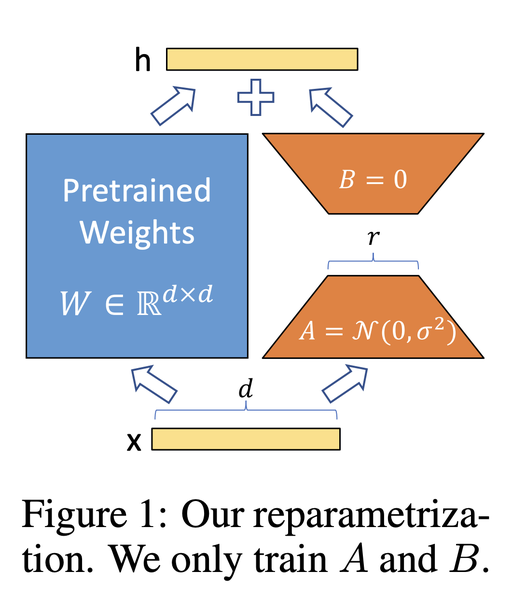

[출처: https://arxiv.org/abs/2106.09685]

학습 시 pretrained model의 initialized weight인 $W_0$는 동결시켜 가중치 업데이트를 하지 않고, 길이 $r$만큼의 low rank를 형성하는 행렬 $A$와 $B$를 업데이트합니다. \
저차원 공간으로 투영된 파라미터는 특정 작업에 더 적합하도록 부분적으로 학습될 수 있습니다. \
전체 파라미터 중 일부분에만 추가적으로 높은 가중치를 두어, 활용하고자 하는 문제에 알맞는 부분만 따로 활성화 하는 방식이라고 이해할 수 있을 것 같습니다. \
LoRA는 대규모 언어 모델의 파라미터 수를 줄여서 학습 속도를 높이고, 과적합을 방지하는 역할을 한다고 알려져있습니다. \
\
Stable diffusion도 모델의 가중치를 전부 업데이트하는 일반적인 미세 조정 방식은 생각보다 훨씬 많은 컴퓨터 연산량을 필요로 하며 결과에 비해 효율적이지 못한 것으로 보입니다. \
때문에 SD 모델 내부의 일부분만을 강조하여 우리가 원하는 이미지 특성만 강조하여 활용하는 방식인 LoRA 가 대중화되었고, \
다양한 LoRA 가중치들을 선택하여 파이프라인에 넣고 활용할 수 있습니다.

---

### **Checkpoint 에 LoRA 덧칠하기**

이제 직접 CHECKPOINT 와 LORA 를 적용하여 다양한 이미지를 생성해보겠습니다.

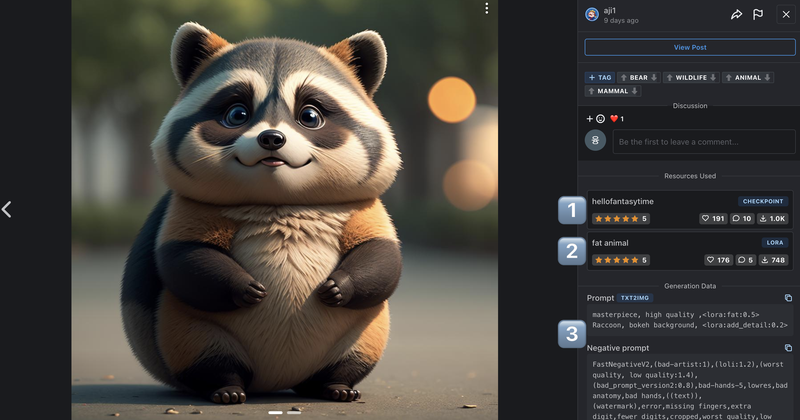

[링크](https://civitai.com/images/1623982?period=AllTime&periodMode=published&sort=Newest&view=categories&modelVersionId=119401&modelId=110738&postId=409355)의 웹페이지를 보시면 샘플 이미지를 재현하기 위한 몇 가지 조건을 확인할 수 있습니다.<br><br>

1. Checkpoint : 직접 다운로드하여 파이프라인에 로드할 수 있고, huggingface 에 이미 업로드 되어있다면 해당 모델 ID 를 넣어 사용할 수 있습니다.
2. LoRA : 상대적으로 적은 용량의 파일이기 떄문에 다운로드하여 활용하겠습니다.
3. promt + negative_prompt : 상세한 프롬프트를 복사해와서 내 상황에 맞게 조금씩 변경하여 입력해줍니다.
4. 기타 조건

<br>먼저 2 의 다운로드 링크를 통해 LoRA 파일을 `lora_example.safetensors` 라는 파일 이름으로 저장해두겠습니다.

In [ ]:
!wget https://civitai.com/api/download/models/116417 -O lora_example.safetensors

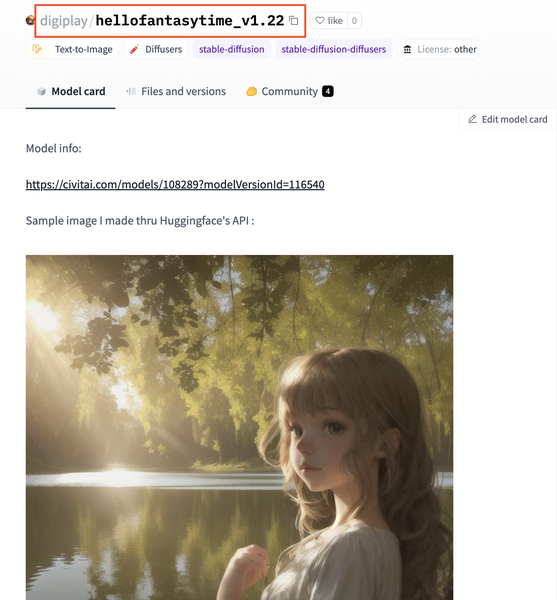

[출처: https://huggingface.co/digiplay/hellofantasytime_v1.22]

필요한 Checkpoint 는 편리하게도 huggingface 에 미리 올려진 상태입니다. 빨간 박스 부분의 이름을 복사하여 아래 코드에 넣어주겠습니다. \
프롬프트와 네거티브 프롬프트도 조금 변경하여 입력하도록 하겠습니다.

In [ ]:
from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler
import torch

pipeline = StableDiffusionPipeline.from_pretrained("digiplay/hellofantasytime_v1.22", torch_dtype=torch.float16)   # 알맞은 모델 ID 를 입력합니다.
pipeline.scheduler = DPMSolverMultistepScheduler.from_config(pipeline.scheduler.config)
pipeline.to("cuda")

pipeline.load_lora_weights("./lora_example.safetensors")   # 다운로드한 LoRA 를 로드합니다.

이미시 생성을 위한 모델 파이프라인이 간단하게 설정되었습니다. \
원하는 요소들을 강조하고싶다면 `prompt`에, 제거하고 싶은 요소가 있다면 `negative_prompt` 인자를 추가하여 적용할 수 있습니다. \
\
이제 프롬프트와 다른 인자들을 알맞게 수정한 후 이미지를 출력해볼까요?

In [ ]:
image = pipeline(
    prompt="masterpiece, high quality ,<lora:fat:0.5> pink cat, in a bucket, bokeh background, <lora:add_detail:0.2>",
    negative_prompt="easynegative,(((pubic))), ((((pubic_hair)))),sketch, duplicate, ugly, huge eyes, text, logo, monochrome, worst face, (bad and mutated hands:1.3), (worst quality:2.0), (low quality:2.0), (blurry:2.0), horror, geometry, (bad hands), (missing fingers), multiple limbs, bad anatomy, (interlocked fingers:1.2), Ugly Fingers, (extra digit and hands and fingers and legs and arms:1.4), crown braid, ((2girl)), (deformed fingers:1.2), (long fingers:1.2),succubus wings,horn,succubus horn,succubus hairstyle,girl,",
    num_inference_steps=28,
    guidance_scale=7,
).images[0]

image.save("sd_lora_sample.png")
image

짠✨ 여러분은 어떤 결과물을 출력되셨나요!?

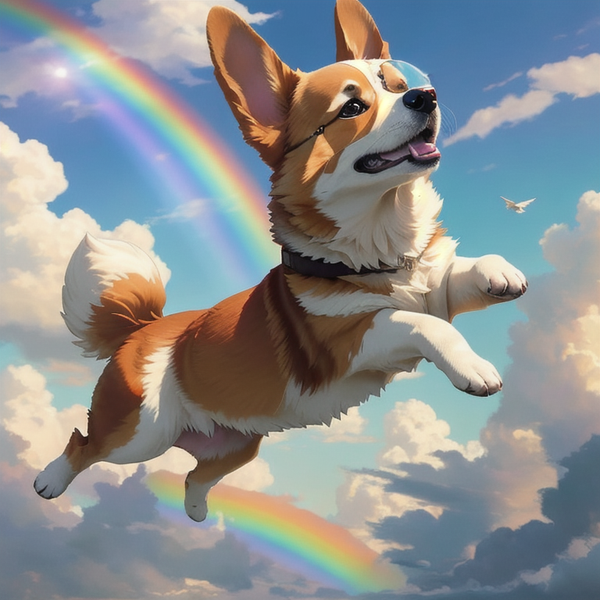

# **27. Stable Diffusion, 너 Do? 나 Do! [프로젝트]**

## **27-1. Project: Stable diffusion 실습**

오늘은 Stable diffusion에 대해서 살펴보았습니다.<br>
이미지 생성 모델을 더 효율적으로 구성하기 위해, 의미적인 공간을 적극적으로 활용한 latent diffusion model 구조를 상세하게 이해해보았습니다.<br>
또한, Huggingface의 예제 코드를 사용하여, 부분적인 미세 조정 과정도 직접 실습해보았고,<br>
웹 상에 공개된 checkpoint와 LoRA를 활용하여 이 세상에 없던 나만의 이미지를 생성해보았습니다.<br>
<br>
이러한 과정들은 현재도 실시간으로 왕성하게 발전되고 있는 분야이면서, 동시에 여러 논란거리를 우리에게 안겨주고 있습니다.<br>
학습에 필요한 데이터와 연관된 저작권 문제와 더불어, 생성 이미지 결과물 자체가 사회에 미치는 윤리적인 문제들이 산재하고 있다는 사실을 꼭 기억해주세요.<br>
<br>
그럼에도 불구하고 엄청난 가능성이 담긴 세계가 새롭게 펼쳐지고 있는것도 사실입니다.<br>
예술 산업 전반에 걸친 창작 활동 과정마다 폭발적인 생산성 도구들이 물밀듯 생겨나고 있고,<br> 우리 생활 곳곳에서 마주칠 수 있는 상품들도 어느 새 성큼 가까워져 있을지 모릅니다.<br>
<br>
여러분은 이렇게 만든 나만의 취향을 어떤 곳에, 어떤 모양으로 사용하고 싶으신가요?

### **Latent 가 어떤 변화를 만들어내는지 체험해봅시다.**
---

- [PyTorch Tutorial](https://daddynkidsmakers.blogspot.com/2024/02/ai-stable-diffusion.html)
- [Colab 실습 코드](https://gist.github.com/kspark-modulabs/1e16667d524cf6d62c30d00ddb72a714)<br><br>

그림에 대한 묘사가 담긴 텍스트 프롬프트를 활용하면, 과적합을 안정적으로 줄이면서 우리가 원하는 기준대로 이미지를 생성할 수 있을 것 같습니다.<br>
Stable diffusion 은 이러한 조건들을 잠재 공간 단위로 조정하면서 꾸준하고도 효율적인 학습과 추론을 수행할 수 있게 되었습니다.<br>
<br>
먼저 원하는 텍스트 프롬프트 4 개를 각각 설정해주세요.<br>
예제에서 제공되는 파이프라인을 재구성하여 함께 준비합니다.

```
prompt_1 = "A watercolor painting of a Golden Retriever at the beach"
prompt_2 = "A still life DSLR photo of a bowl of fruit"
prompt_3 = "The eiffel tower in the style of starry night"
prompt_4 = "An architectural sketch of a skyscraper"
```

모델을 사용해 프롬프트를 임베딩 형태로 변환하고, 선형 보간을 통해 중간 지점을 만들어 직접 시각화해보세요.<br>
잠재 공간의 매니폴드 구조를 떠올리면서 중간 지점의 생성 이미지들을 관찰하고, 눈에 띄는 이미지적 특성들을 분석하여 정리해보세요.

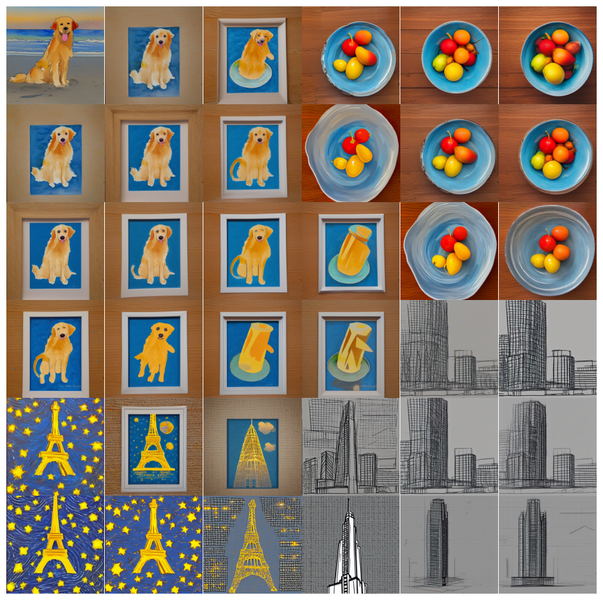

### **(+Optional)**

자료의 `A circular walk through the diffusion noise space for a single prompt` 부분을 읽고, `unconditional guidance scale` 인자의 역할에 대해 설명해보세요

<img src="https://keras.io/img/examples/generative/random_walks_with_stable_diffusion/happycows.gif">

(출처:https://keras.io/examples/generative/random_walks_with_stable_diffusion/)

### **Stable diffusion 모델로 내가 원하는 대상을 녹여내봅시다.**
---

실습 코드로는 data 폴더 내에 `Stable_Diffusion(2).ipynb` 파일이 준비되어 있습니다.<br>
Stable diffusion 모델의 미세조정 방식 중 Dreambooth 기법을 실습해보세요.<br>
내가 원하는 대상의 이미지를 각각 Instance 5-6장, Class 100장 이상을 모아 폴더 경로를 맞춰줍니다. prompt도 적절히 알맞게 설정하고 미세조정을 수행해보세요.

### **Stable diffusion 모델을 자유롭게 요모조모 다뤄봅시다.**
---

> ⛔️ 타인에게 불쾌감을 줄 수 있는 행위나 이미지에 주의해주시기 바랍니다.⚠

<br>[웹사이트](https://civitai.com/) 안에는 무궁무진한 가능성이 담겨있습니다. 많은 작업자들이 본인의 감각을 저장해 둔 파일을 편리하게 다운로드 받아 파이프라인에 적용해보세요.<br>
checkpoint 와 LoRA 를 잘 조합하다보면 맘에 쏙 드는 근사한 그림을 만들수 있습니다!

```
model_id = "digiplay/hellofantasytime_v1.22"

...

pipeline.load_lora_weights("./lora_weight.safetensors")
```

## **27-2. 프로젝트 제출**

### 루브릭

아래의 기준을 바탕으로 프로젝트를 평가합니다.<br>
<br>

|평가문항|상세기준|
|-|-|
|<br>1. 잠재적 표현의 변화가 모델 출력에 미치는<br> 영향을 관찰하였는가?<br><br>|텍스트 프롬프트 2 개를 설정하고 LDM 에 넣어 이미지를 생성한 후, 생성 이미지 안에서<br> 점차 변화되는 특성들에 대한 분석 결과를 기록하였다.|
|<br>2. Stable diffusion 모델의 dreambooth<br> 미세조정을 실습하였는가?<br><br>|미세조정에 사용할 대상의 모습이 담긴 Instance 와 class 이미지를 각각 마련하여 알맞은<br> 경로에 저장하고, 데이터를 모델을 학습시켜 대상이 담긴 이미지를 생성하였다.|
|<br>3. 나만의 취향이 담긴 생성 이미지를<br> 만들어보았는가?<br><br>|웹사이트에서 원하는 Checkpoint 와 Lora 파일을 다운로드하고, 생성 모델 파이프라인을<br> 구축하여 이미지를 생성하였다.|

### 프로젝트 제출

프로젝트 제출 방법 안내